In this notebook we shall present a simple conditional VAE, trained on MNIST

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import utils
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

The conditional autoencoder will allow to generate specific digits in the MNIST range 0-9. The condition is passed as input to encoder and decoder in categorical format.

In [2]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

11490434/11490434 [==============================] - 1s 0us/step


# The model

Sampling function for the Variational Autoencoder.
This is the clsed form of the Kullback-Leibler distance between a gaussian N(z_mean,z_var) and a normal prior N(0,1)

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

Main dimensions for the model (a simple stack of dense layers).

In [4]:
input_dim = 784
latent_dim = 8
intermediate_dim = 25

We start with the encoder. It takes two inputs: the image and the category.

It returns the latent encoding (z_mean) and a (log-)variance for each latent variable.

In [5]:
x = layers.Input(shape=(input_dim,))
y = layers.Input(shape=(10,))
xy = layers.concatenate([x,y])
h = layers.Dense(intermediate_dim, activation='relu')(xy)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

Now we sample around z_mean with the associated variance. 

Note the use of the "lambda" layer to transform the sampling function into a keras layer.

In [10]:
# in order to transfor a function into a layer we use the Lambda layer, we specify the output shape and the paramter passed to the function
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

Now we need to address the decoder. We first define its layers, in order to use them both in the vae model and in the stand-alone generator.

In [11]:
decoder_mid = layers.Dense(intermediate_dim, activation='relu')
decoder_out = layers.Dense(input_dim, activation='sigmoid')

We decode the image starting from the latent representation z and its category y, that must be concatenated.

In [12]:
zy = layers.concatenate([z,y])
dec_mid = decoder_mid(zy)
x_hat = decoder_out(dec_mid)

vae = Model(inputs=[x,y], outputs=[x_hat])

Some hyperparameters. Gamma is used to balance loglikelihood and KL-divergence in the loss function

In [13]:
batch_size = 100
epochs = 50
gamma = .5

The VAE loss function is just the sum between the reconstruction error (mse or bce) and the KL-divergence, acting as a regularizer of the latent space.

In [14]:
rec_loss = input_dim * metrics.binary_crossentropy(x, x_hat)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(rec_loss + gamma*kl_loss)
vae.add_loss(vae_loss)

We are ready to compile. There is no need to specify the loss function, since we already added it to the model with add_loss.

In [15]:
vae.compile(optimizer='adam')

Train for a sufficient amount of epochs. Generation is a more complex task than classification.

In [21]:
vae.fit([x_train,y_train], shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=([x_test,y_test], None))

vae.save_weights("cvae256_8.h5")

Epoch 1/50
600/600 [==============================] - 2s 4ms/step - loss: 116.4013 - val_loss: 115.4058
Epoch 2/50
600/600 [==============================] - 2s 4ms/step - loss: 116.3562 - val_loss: 115.4468
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 116.3184 - val_loss: 115.3506
Epoch 4/50
600/600 [==============================] - 3s 4ms/step - loss: 116.2852 - val_loss: 115.3366
Epoch 5/50
600/600 [==============================] - 2s 4ms/step - loss: 116.2744 - val_loss: 115.3901
Epoch 6/50
600/600 [==============================] - 2s 4ms/step - loss: 116.2610 - val_loss: 115.3654
Epoch 7/50
600/600 [==============================] - 2s 4ms/step - loss: 116.2400 - val_loss: 115.2858
Epoch 8/50
600/600 [==============================] - 3s 4ms/step - loss: 116.2160 - val_loss: 115.2138
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 116.1916 - val_loss: 115.3137
Epoch 10/50
600/600 [==============================] - 2s 4ms/st

Let us decode the full training set.

In [22]:
decoded_imgs = vae.predict([x_test,y_test])

313/313 [==============================] - 1s 2ms/step


The following function is to test the quality of reconstructions (not particularly good, since compression is strong).

In [23]:
def plot(n=10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

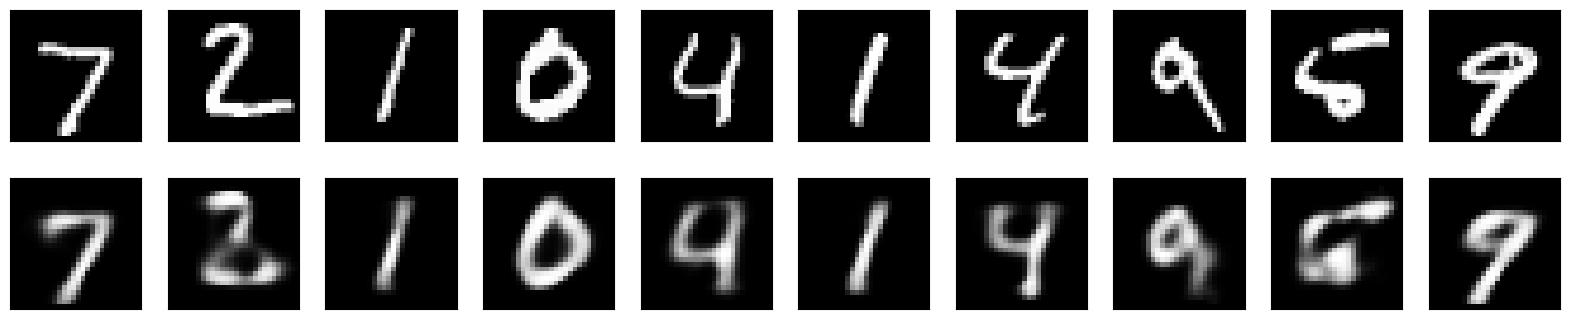

In [24]:
plot()

Finally, we build a digit generator that can sample from the learned distribution

In [25]:
noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(10,))
xy = layers.concatenate([noise,label])
dec_mid = decoder_mid(xy)
dec_out = decoder_out(dec_mid)
generator = Model([noise,label],dec_out)

And we can generate our samples

input digit to generate: 7
1/1 [==============================] - 0s 20ms/step


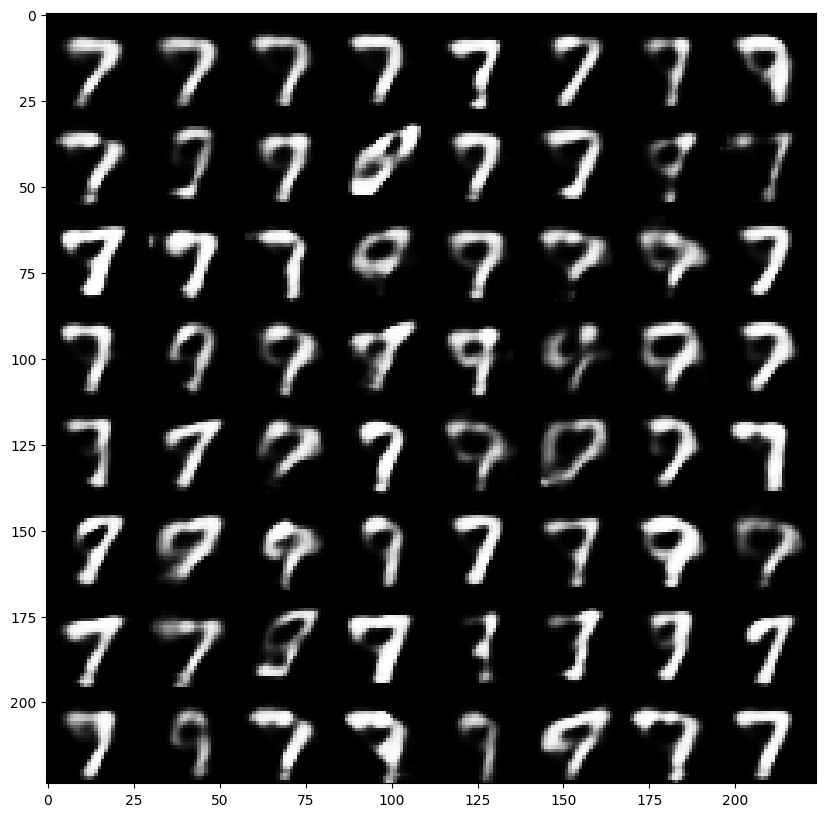

input digit to generate: 3
1/1 [==============================] - 0s 24ms/step


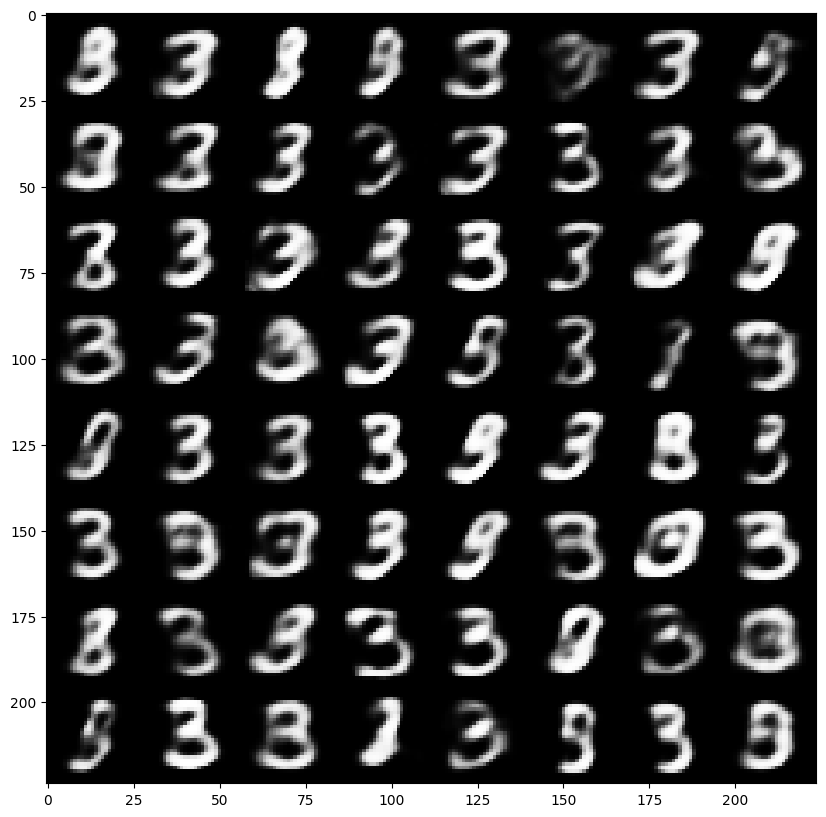

input digit to generate: -1
-1


In [26]:
import time
# display a 2D manifold of the digits
n = 8  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

while True:
  label = input("input digit to generate: ")
  label = int(label)
  if label < 0 or label > 9:
      print(label)
      break
  label = np.expand_dims(utils.to_categorical(label,10),axis=0)
  for i in range(0,n):
    for j in range (0,n):
        z_sample = np.expand_dims(np.random.normal(size=latent_dim),axis=0)
        x_decoded = generator.predict([z_sample,label])
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
  plt.figure(figsize=(10, 10))
  plt.imshow(figure, cmap='Greys_r')
  plt.show()
  time.sleep(1)
